<a href="https://colab.research.google.com/github/Vigna200/FMML_Project_Labs/blob/main/AIML_Module_4_Lab_2_Introduction_to_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Training Program on AIML**
# Module 4: Perceptron and Gradient Descent
## Lab 2: Introduction to Gradient Descent

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is


*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$



In [1]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [112]:
def eval_5th_degree(coeffs, x):
    """
    Function to return the output of evaluating a fifth degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c , d ,e,f for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x * x *x*x)
    b = coeffs[1] * (x * x*x*x)
    c = coeffs[2] * (x*x*x)
    d =coeffs[3]*(x*x)
    e=coeffs[4]*x
    f=coeffs[5]
    y = a + b + c + d+e+f
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1,-1,2,-2,1,-1]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_3rd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

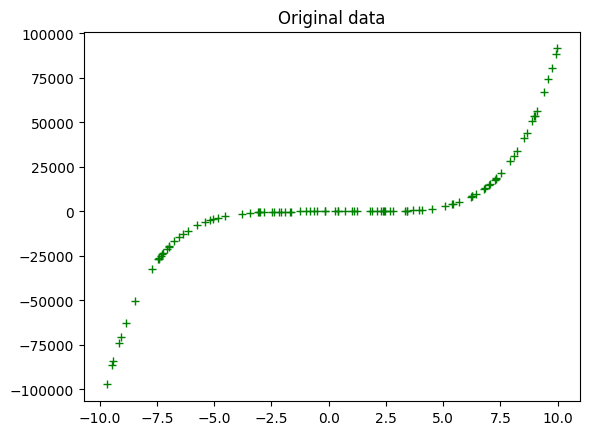

In [113]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [114]:
def eval_5th_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c,d,e,f for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x **5)
    b = coeffs[1] * (x**4)
    c = coeffs[2] * (x**3)
    d=coeffs[3]*(x**2)
    e=coeffs[4]*x
    f=coeffs[5]
    y = a + b + c + d+e+f

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_5th_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


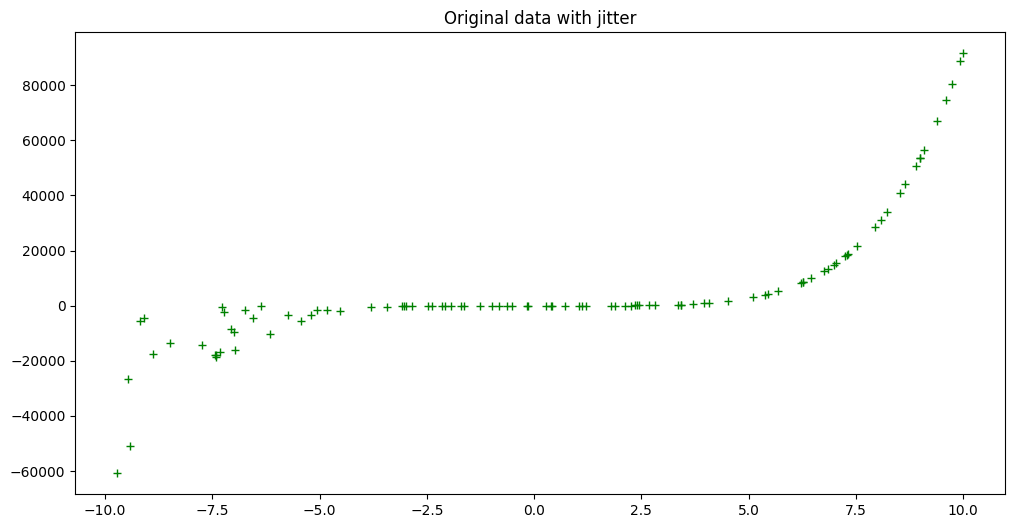

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [116]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

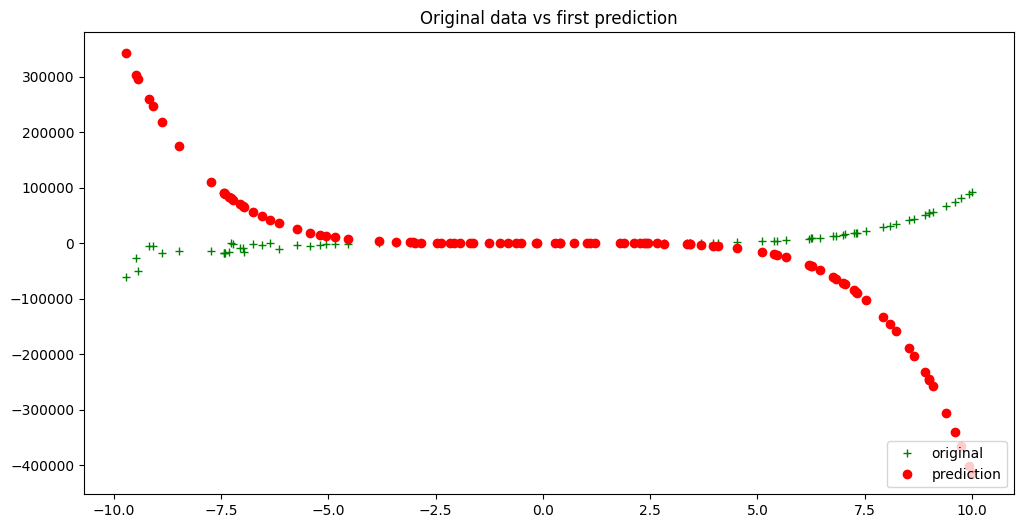

In [117]:
rand_coeffs = (random.randrange(-10, 10),random.randrange(-10, 10),random.randrange(-10, 10),random.randrange(-10, 10) ,random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_5th_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [118]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

23804623673.811085

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [119]:
def calc_gradient_5th_poly(rand_coeffs, hundred_xs, ys):
    """
    Calculates the gradient for a 5th-degree polynomial.

    Args:
        rand_coeffs: Coefficients for the 5th-degree polynomial (a, b, c, d, e, f).
        hundred_xs: Input data points (x values).
        ys: Actual output values (y values).

    Returns:
        Tuple containing the gradients for each coefficient (gradient_a, gradient_b, gradient_c, gradient_d, gradient_e, gradient_f).
    """
    a_s = []
    b_s = []
    c_s = []
    d_s = []
    e_s = []
    f_s = []

    y_bars = eval_5th_degree(rand_coeffs, hundred_xs)  # Use eval_5th_degree for predictions

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):
        partial_a = (x ** 5) * (y - y_bar)
        a_s.append(partial_a)
        partial_b = (x ** 4) * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (x ** 3) * (y - y_bar)
        c_s.append(partial_c)
        partial_d = (x ** 2) * (y - y_bar)
        d_s.append(partial_d)
        partial_e = x * (y - y_bar)
        e_s.append(partial_e)
        partial_f = (y - y_bar)  # Constant term
        f_s.append(partial_f)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)
    gradient_d = (-2 / n) * sum(d_s)
    gradient_e = (-2 / n) * sum(e_s)
    gradient_f = (-2 / n) * sum(f_s)

    return (gradient_a, gradient_b, gradient_c, gradient_d, gradient_e, gradient_f)  # Return all 6 gradients

In [120]:
calc_grad = calc_gradient_5th_poly(rand_coeffs, hundred_xs, ys)  # Use calc_gradient_5th_poly
lr = 0.0001
# Update all 6 coefficients (a, b, c, d, e, f)
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]
d_new = rand_coeffs[3] - lr * calc_grad[3]
e_new = rand_coeffs[4] - lr * calc_grad[4]
f_new = rand_coeffs[5] - lr * calc_grad[5]
new_model_coeffs = (a_new, b_new, c_new, d_new, e_new, f_new)
print(f"New model coeffs: {new_model_coeffs}")

new_y_bar = eval_5th_degree(new_model_coeffs, hundred_xs)  # Use eval_5th_degree
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (978429.2760758406, 34617.28556692567, 11865.815740390512, 391.9345573385048, 160.7574635002372, 13.523357119340858)
Now have smaller model loss: 9.702893713395954e+20 vs 23804623673.811085


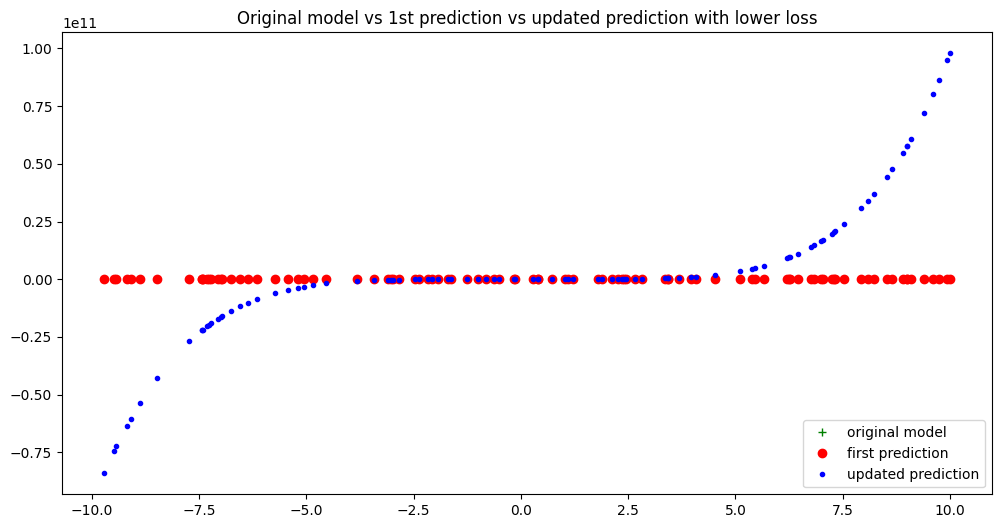

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original model')
plt.plot(xs, y_bar, 'ro', label = 'first prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [122]:
def calc_gradient_5th_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    Calculates the gradient for a 5th-degree polynomial.

    Args:
        coeffs: Coefficients for the 5th-degree polynomial (a, b, c, d, e, f).
        inputs_x: Input data points (x values).
        outputs_y: Actual output values (y values).
        lr: Learning rate.

    Returns:
        Tuple containing the updated model loss, new model coefficients,
        new predictions, and gradients.
    """
    gradients = [[] for _ in range(6)]  # Initialize gradients for all 6 coefficients

    y_bars = eval_5th_degree(coeffs, inputs_x)  # Use eval_5th_degree for predictions

    for x, y, y_bar in list(zip(inputs_x, outputs_y, y_bars)):
        for i in range(6):
            partial = (x ** (5 - i)) * (y - y_bar)
            gradients[i].append(partial)

    n = len(y_bars)
    gradients = [(-2 / n) * sum(g) for g in gradients]  # Calculate gradients for each coefficient

    # Update all 6 coefficients (a, b, c, d, e, f)
    new_coeffs = [coeffs[i] - lr * gradients[i] for i in range(6)]

    # Update with these new coeffs using eval_5th_degree
    new_y_bar = eval_5th_degree(new_coeffs, inputs_x)  # Use eval_5th_degree
    updated_model_loss = loss_mse(outputs_y, new_y_bar)

    return updated_model_loss, new_coeffs, new_y_bar, gradients  # Return all 6 gradients

In [123]:
def gradient_descent(epochs, initial_lr, hundred_xs, ys, tolerance=1e-6, rand_coeffs=None):
    """
    Perform gradient descent for a 5th-degree polynomial with manual scaling/normalization.

    Args:
        epochs: Maximum number of iterations.
        initial_lr: Initial learning rate.
        hundred_xs: Input data (to be scaled).
        ys: Output data (to be normalized).
        tolerance: Convergence tolerance for loss.
        rand_coeffs: Initial coefficients (optional). If None, uses [1, 1, 1, 1, 1, 1].

    Returns:
        Tuple containing (final_loss, final_coeffs, final_y_bar_predictions, loss_history).
    """
    # Manual feature scaling
    x_mean = np.mean(hundred_xs)
    x_std = np.std(hundred_xs)
    hundred_xs_scaled = (hundred_xs - x_mean) / x_std

    # Manual output normalization
    y_mean = np.mean(ys)
    y_std = np.std(ys)
    ys_normalized = (ys - y_mean) / y_std

    losses = []
    coeffs = rand_coeffs if rand_coeffs is not None else [1, 1, 1, 1, 1, 1]  # Use provided or default coeffs
    lr = initial_lr
    prev_loss = float('inf')

    for epoch in range(epochs):
        loss, new_coeffs, new_y_bar, gradients = calc_gradient_5th_poly_for_GD(coeffs, hundred_xs_scaled, ys_normalized, lr)  # Use calc_gradient_5th_poly_for_GD
        coeffs = new_coeffs
        losses.append(loss)

        # Learning rate decay
        lr *= 0.99

        # Stopping criterion
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged after {epoch + 1} epochs.")
            break

        prev_loss = loss

    print(f"Final Loss: {loss}")
    print(f"Final Coefficients: {coeffs}")

    return loss, coeffs, new_y_bar, losses

In [100]:
GD = gradient_descent(30000, 0.0003, hundred_xs, ys)


Converged after 1355 epochs.
Final Loss: 196.13384961355197
Final Coefficients: (6.498892537423083, 8.505181868621232, 1.2317236094394963, -5.190439218042835)


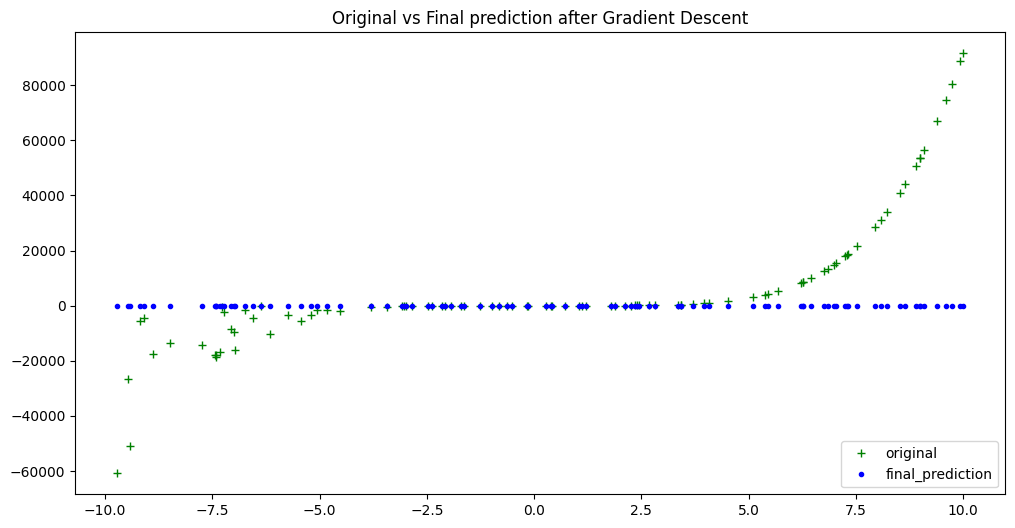

In [124]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [125]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: [-0.9198471388731622, -0.9612005524424313, -0.9670164355789964, -0.9840657970333299, -0.9852462189827454, -0.9915032787262151]
Original Coefficients: [1, -1, 2, -2, 1, -1]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


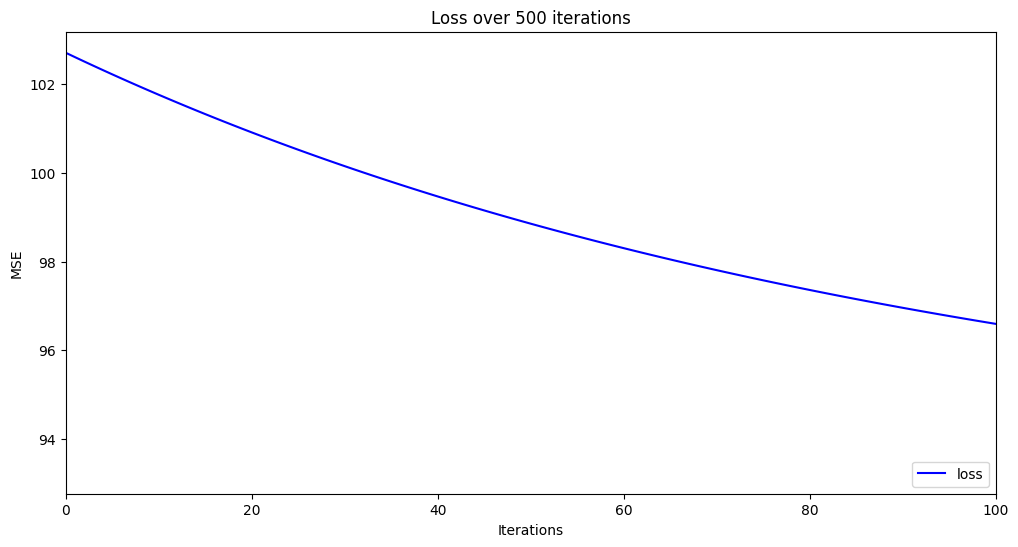

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
# plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlim((0,100))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss after about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached. This would prevent excessive training and potential over-fitting for the model.

# Things to try



1.   Change the coefficients array and try a different polynomial instead of our $x^2$.
2.   Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?



2. By decreasing the learning rate the step size becomes smaller and the model takes more steps to converge. This increases time on convergence . The decrease in learning rate improves the precision and reduces oscillations. On increasing the learning rate the step size increases this leads to reduction in loss function. Gradient Functions becomes larger. Due to the large steps we might face fluctuations . Due to less iterations the learning set can be appropriately set.

3. For a 5 degree polynomial initialization matters because the function has multiple roots and local minima. Gradient descent can converge to different roots or minima depending on where you start.For quadratic function initialization doesn't matter because the function is convex with a single global minimum at x=0. No matter where you start, gradient descent will always converge to the same minimum. Hence the intialization don't matter in quadratic polynomial.

In [129]:
#4
def gradient_ascent(epochs, initial_lr, hundred_xs, ys, tolerance=1e-6, rand_coeffs=None):
    x_mean = np.mean(hundred_xs)
    x_std = np.std(hundred_xs)
    hundred_xs_scaled = (hundred_xs - x_mean) / x_std
    y_mean = np.mean(ys)
    y_std = np.std(ys)
    ys_normalized = (ys - y_mean) / y_std
    losses = []
    coeffs = rand_coeffs if rand_coeffs is not None else [1, 1, 1, 1, 1, 1]  # Use provided or default coeffs
    lr = initial_lr
    prev_loss = float('-inf')
    for epoch in range(epochs):
        loss, new_coeffs, new_y_bar, gradients = calc_gradient_5th_poly_for_GD(coeffs, hundred_xs_scaled, ys_normalized, lr)  # Use calc_gradient_5th_poly_for_GD
        coeffs = [coeffs[i] + lr * gradients[i] for i in range(6)]  # Gradient Ascent update
        losses.append(loss)
        lr *= 0.99
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged after {epoch + 1} epochs.")
            break
        prev_loss = loss
    print(f"Final Loss: {loss}")
    print(f"Final Coefficients: {coeffs}")
    return loss, coeffs, new_y_bar, losses
GA = gradient_ascent(30000, 0.0003, hundred_xs, ys)

Converged after 1628 epochs.
Final Loss: 476.3601385673589
Final Coefficients: [3.942159164504633, 1.4612963732713629, 2.3081168939826333, 1.2965256738650757, 1.627523570220034, 1.2263228905317627]


## **Additional Critical Thinking Questions**

1. You are doing full batch gradient descent using the entire training set. Is it necessary to shuffle the training data? Explain your
answer.

2. You would like to train a dog/cat image classifier using mini-batch gradient
descent. You have already split your dataset into train, dev and test sets. The classes
are balanced. You realize that within the training set, the images are ordered in such a
way that all the dog images come first and all the cat images come after. A friend tells
you: ”you absolutely need to shuffle your training set before the training procedure.”
Is your friend right? Explain.

1. While doing a full batch gradient descent using entire training set according to me there is no need to shuffle the training data because the gradient is computed for dataset so there no reason to shuffle.But for some methods such as stochastic and mini-batch gradient descent, we need to shuffle the datasets because the order of data is important in learning process for such methods.

2. Yes, I would agree with my friend because as the training set is ordered the mini-batches can be biased and the model would not learn a balanced representations and this can also lead to poor generalization .To improve the generalization we need to shuffel the dataset such that when we take mini-batches each must contain both classes and one more drawback of not shuffling is the model might see similar cases and can not perform well ,even the gradient updates are similar. Hence while performing mini-batch method it is necessary to shuffle the dataset. Hence I agree with what my friend has stated.

